# ELAIS-N1 master catalogue

This notebook presents the merge of the various pristine catalogues to produce HELP mater catalogue on ELAIS-N1.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
wfc = Table.read("{}/INT-WFC.fits".format(TMP_DIR))
dxs = Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR))
sparcs = Table.read("{}/SpARCS.fits".format(TMP_DIR))
hsc = Table.read("{}/HSC-SSP.fits".format(TMP_DIR))
ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))
servs = Table.read("{}/SERVS.fits".format(TMP_DIR))
swire= Table.read("{}/SWIRE.fits".format(TMP_DIR))

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones: WFC, DXS, SpARCS, HSC, PS1, SERVS, SWIRE.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### WFC

In [5]:
master_catalogue = wfc
master_catalogue['wfc_ra'].name = 'ra'
master_catalogue['wfc_dec'].name = 'dec'

### Add SpARCS

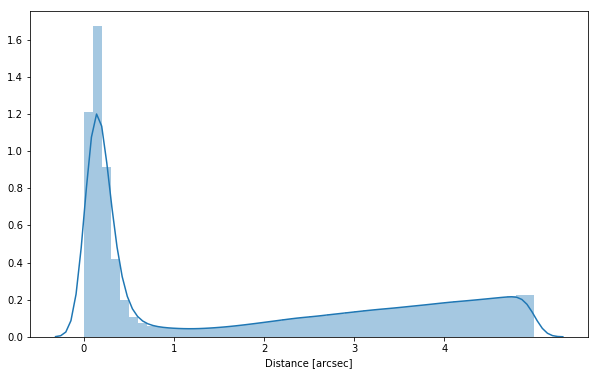

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(sparcs['sparcs_ra'], sparcs['sparcs_dec'])
)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, sparcs, "sparcs_ra", "sparcs_dec", radius=0.8*u.arcsec)

### Add HSC-PSS

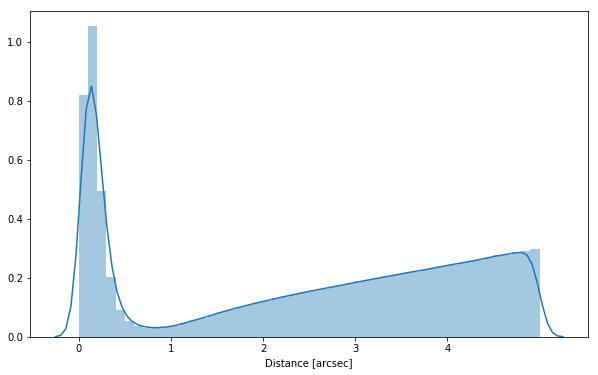

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(hsc['hsc_ra'], hsc['hsc_dec'])
)

In [9]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, hsc, "hsc_ra", "hsc_dec", radius=0.8*u.arcsec)

### Add PanSTARRS

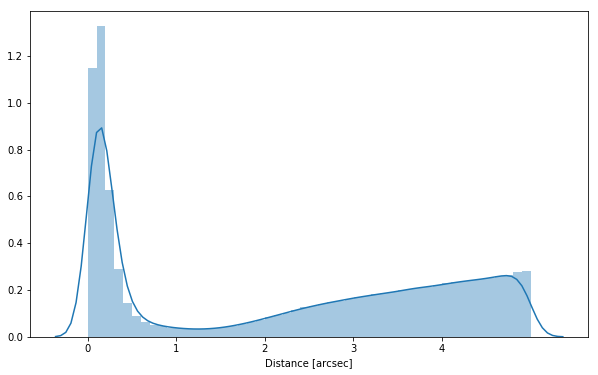

In [10]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(ps1['ps1_ra'], ps1['ps1_dec'])
)

In [11]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, ps1, "ps1_ra", "ps1_dec", radius=0.8*u.arcsec)

### Add DXS

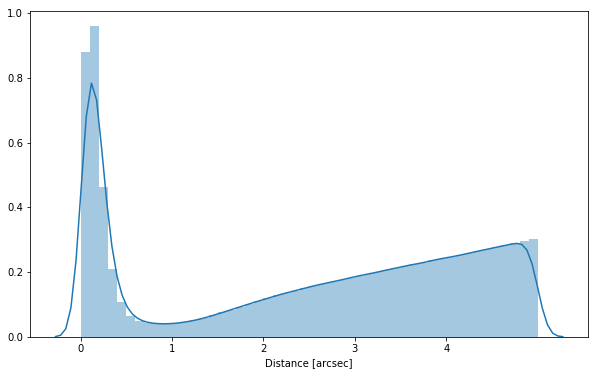

In [12]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(dxs['dxs_ra'], dxs['dxs_dec'])
)

In [13]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, dxs, "dxs_ra", "dxs_dec", radius=0.8*u.arcsec)

### Add SERVS

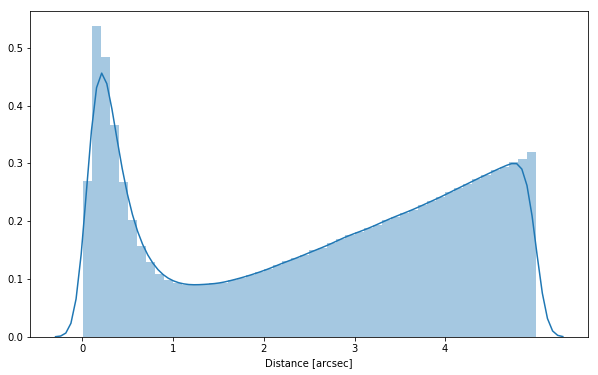

In [14]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(servs['servs_ra'], servs['servs_dec'])
)

In [15]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, servs, "servs_ra", "servs_dec", radius=1.*u.arcsec)

### Add SWIRE

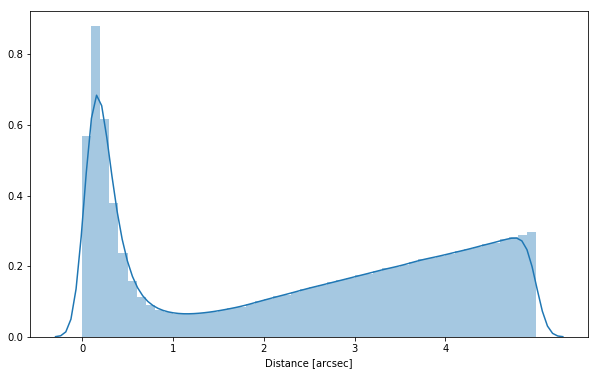

In [16]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(swire['swire_ra'], swire['swire_dec'])
)

In [17]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, swire, "swire_ra", "swire_dec", radius=1.*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [18]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [19]:
master_catalogue[:10].show_in_notebook()

idx,wfc_id,ra,dec,wfc_stellarity,m_ap_wfc_u,merr_ap_wfc_u,m_wfc_u,merr_wfc_u,m_ap_wfc_g,merr_ap_wfc_g,m_wfc_g,merr_wfc_g,m_ap_wfc_r,merr_ap_wfc_r,m_wfc_r,merr_wfc_r,m_ap_wfc_i,merr_ap_wfc_i,m_wfc_i,merr_wfc_i,m_ap_wfc_z,merr_ap_wfc_z,m_wfc_z,merr_wfc_z,f_ap_wfc_u,ferr_ap_wfc_u,f_wfc_u,ferr_wfc_u,flag_wfc_u,f_ap_wfc_g,ferr_ap_wfc_g,f_wfc_g,ferr_wfc_g,flag_wfc_g,f_ap_wfc_r,ferr_ap_wfc_r,f_wfc_r,ferr_wfc_r,flag_wfc_r,f_ap_wfc_i,ferr_ap_wfc_i,f_wfc_i,ferr_wfc_i,flag_wfc_i,f_ap_wfc_z,ferr_ap_wfc_z,f_wfc_z,ferr_wfc_z,flag_wfc_z,wfc_flag_cleaned,wfc_flag_gaia,flag_merged,sparcs_intid,sparcs_stellarity,m_ap_megacam_u,merr_ap_megacam_u,f_ap_megacam_u,ferr_ap_megacam_u,m_megacam_u,merr_megacam_u,f_megacam_u,ferr_megacam_u,flag_megacam_u,m_ap_megacam_g,merr_ap_megacam_g,f_ap_megacam_g,ferr_ap_megacam_g,m_megacam_g,merr_megacam_g,f_megacam_g,ferr_megacam_g,flag_megacam_g,m_ap_megacam_r,merr_ap_megacam_r,f_ap_megacam_r,ferr_ap_megacam_r,m_megacam_r,merr_megacam_r,f_megacam_r,ferr_megacam_r,flag_megacam_r,m_ap_megacam_z,merr_ap_megacam_z,f_ap_megacam_z,ferr_ap_megacam_z,m_megacam_z,merr_megacam_z,f_megacam_z,ferr_megacam_z,flag_megacam_z,sparcs_flag_cleaned,sparcs_flag_gaia,hsc_id,m_ap_suprime_g,merr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_r,merr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_i,merr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_z,merr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_y,merr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_n921,merr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,hsc_stellarity,f_ap_suprime_g,ferr_ap_suprime_g,f_suprime_g,ferr_suprime_g,flag_suprime_g,f_ap_suprime_r,ferr_ap_suprime_r,f_suprime_r,ferr_suprime_r,flag_suprime_r,f_ap_suprime_i,ferr_ap_suprime_i,f_suprime_i,ferr_suprime_i,flag_suprime_i,f_ap_suprime_z,ferr_ap_suprime_z,f_suprime_z,ferr_suprime_z,flag_suprime_z,f_ap_suprime_y,ferr_ap_suprime_y,f_suprime_y,ferr_suprime_y,flag_suprime_y,f_ap_suprime_n921,ferr_ap_suprime_n921,f_suprime_n921,ferr_suprime_n921,flag_suprime_n921,hsc_flag_cleaned,hsc_flag_gaia,ps1_id,m_ap_gpc1_g,merr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_r,merr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_i,merr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_z,merr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_y,merr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,f_ap_gpc1_g,ferr_ap_gpc1_g,f_gpc1_g,ferr_gpc1_g,flag_gpc1_g,f_ap_gpc1_r,ferr_ap_gpc1_r,f_gpc1_r,ferr_gpc1_r,flag_gpc1_r,f_ap_gpc1_i,ferr_ap_gpc1_i,f_gpc1_i,ferr_gpc1_i,flag_gpc1_i,f_ap_gpc1_z,ferr_ap_gpc1_z,f_gpc1_z,ferr_gpc1_z,flag_gpc1_z,f_ap_gpc1_y,ferr_ap_gpc1_y,f_gpc1_y,ferr_gpc1_y,flag_gpc1_y,ps1_flag_cleaned,ps1_flag_gaia,dxs_id,m_ap_ukidss_j,merr_ap_ukidss_j,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_k,merr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,dxs_stellarity,f_ap_ukidss_j,ferr_ap_ukidss_j,f_ukidss_j,ferr_ukidss_j,flag_ukidss_j,f_ap_ukidss_k,ferr_ap_ukidss_k,f_ukidss_k,ferr_ukidss_k,flag_ukidss_k,dxs_flag_cleaned,dxs_flag_gaia,servs_intid,f_ap_servs_irac_i1,ferr_ap_servs_irac_i1,f_servs_irac_i1,ferr_servs_irac_i1,servs_stellarity_irac_i1,f_ap_servs_irac_i2,ferr_ap_servs_irac_i2,f_servs_irac_i2,ferr_servs_irac_i2,servs_stellarity_irac_i2,m_ap_servs_irac_i1,merr_ap_servs_irac_i1,m_servs_irac_i1,merr_servs_irac_i1,flag_servs_irac_i1,m_ap_servs_irac_i2,merr_ap_servs_irac_i2,m_servs_irac_i2,merr_servs_irac_i2,flag_servs_irac_i2,servs_flag_cleaned,servs_flag_gaia,swire_intid,f_ap_swire_irac_i1,ferr_ap_swire_irac_i1,f_swire_irac_i1,ferr_swire_irac_i1,swire_stellarity_irac_i1,f_ap_swire_irac_i2,ferr_ap_swire_irac_i2,f_swire_irac_i2,ferr_swire_irac_i2,swire_stellarity_irac_i2,f_ap_irac_i3,ferr_ap_irac_i3,f_irac_i3,ferr_irac_i3,swire_stellarity_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,f_irac_i4,ferr_irac_i4,swire_stellarity_irac_i4,m_ap_swire_irac_i1,merr_ap_swire_irac_i1,m_swire_irac_i1,merr_swire_irac_i1,flag_swire_irac_i1,m_ap_swire_irac_i2,merr_ap_swire_irac_i2,m_swire_irac_i2,merr_swire_irac_i2,flag_swire_irac_i2,m_ap_irac_i3,merr_ap_irac_i3,m_irac_i3,merr_irac_i3

## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [20]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [21]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.  We keep trace of the origin of the stellarity.

In [22]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

print(", ".join(stellarity_columns))

wfc_stellarity, sparcs_stellarity, hsc_stellarity, dxs_stellarity, servs_stellarity_irac_i1, servs_stellarity_irac_i2, swire_stellarity_irac_i1, swire_stellarity_irac_i2, swire_stellarity_irac_i3, swire_stellarity_irac_i4


In [23]:
# We create an masked array with all the stellarities and get the maximum value, as well as its
# origin.  Some sources may not have an associated stellarity.
stellarity_array = np.array([master_catalogue[column] for column in stellarity_columns])
stellarity_array = np.ma.masked_array(stellarity_array, np.isnan(stellarity_array))

max_stellarity = np.max(stellarity_array, axis=0)
max_stellarity.fill_value = np.nan

no_stellarity_mask = max_stellarity.mask

master_catalogue.add_column(Column(data=max_stellarity.filled(), name="stellarity"))

stellarity_origin = np.full(len(master_catalogue), "NO_INFORMATION", dtype="S20")
stellarity_origin[~no_stellarity_mask] = np.array(stellarity_columns)[np.argmax(stellarity_array, axis=0)[~no_stellarity_mask]]

master_catalogue.add_column(Column(data=stellarity_origin, name="stellarity_origin"))

master_catalogue.remove_columns(stellarity_columns)

## IV - Adding E(B-V) column

In [24]:
master_catalogue.add_column(
    ebv(master_catalogue['ra'], master_catalogue['dec'])
)

## V - Adding HELP unique identifiers and field columns

In [25]:
master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
                                   name="help_id"))
master_catalogue.add_column(Column(np.full(len(master_catalogue), "ELAIS-N1", dtype='<U18'),
                                   name="field"))

In [26]:
# Check that the HELP Ids are unique
if len(master_catalogue) != len(np.unique(master_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


## VI - Cross-matching with spec-z catalogue

In [27]:
specz =  Table.read("../../dmu23/dmu23_ELAIS-N1/data/ELAIS-N1-specz-v2.1.fits")

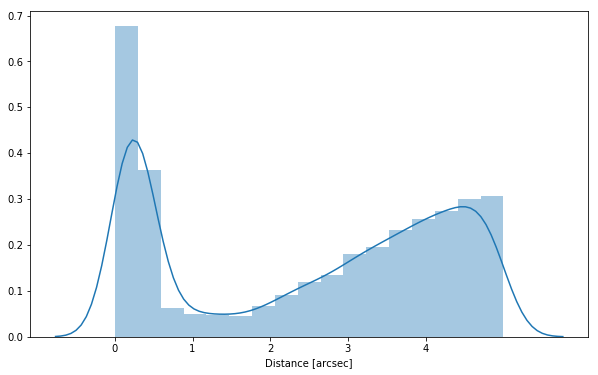

In [28]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [29]:
master_catalogue = specz_merge(master_catalogue, specz, radius=1. * u.arcsec)

## VII - Choosing between multiple values for the same filter

Both SERVS and SWIRE provide IRAC1 and IRAC2 fluxes. SERVS is deeper but tends to under-estimate flux of bright sources (Mattia said over 2000 µJy) as illustrated by this comparison of SWIRE, SERVS, and Spitzer-EIP fluxes.

In [30]:
seip = Table.read("../../dmu0/dmu0_SEIP/data/SEIP_ELAIS-N1.fits")
seip_coords = SkyCoord(seip['ra'], seip['dec'])
idx, d2d, _ = seip_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
mask = d2d <= 2 * u.arcsec

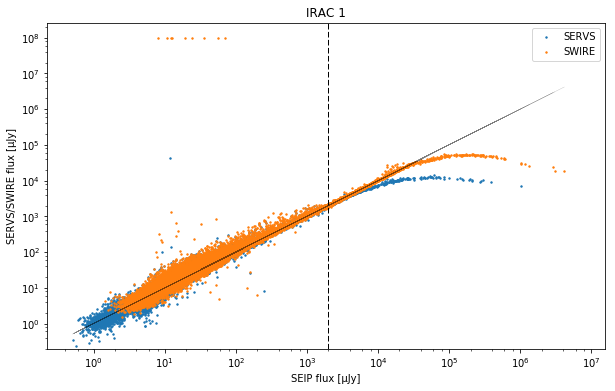

In [31]:
fig, ax = plt.subplots()
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_servs_irac_i1'], label="SERVS", s=2.)
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_swire_irac_i1'], label="SWIRE", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SERVS/SWIRE flux [μJy]")
ax.set_title("IRAC 1")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)
ax.plot(seip['i1_f_ap1'][mask], seip['i1_f_ap1'][mask], linewidth=.1, color="black", alpha=.5);

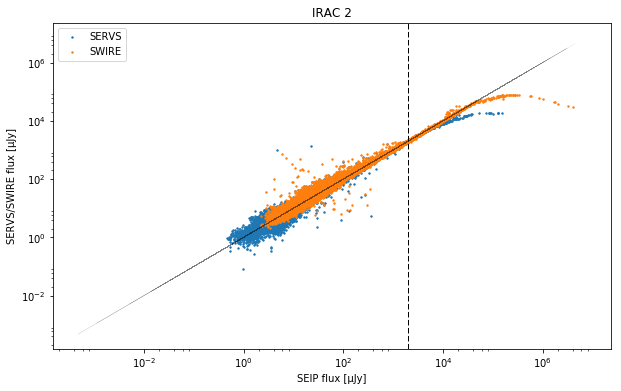

In [32]:
fig, ax = plt.subplots()
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_servs_irac_i2'], label="SERVS", s=2.)
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_swire_irac_i2'], label="SWIRE", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SERVS/SWIRE flux [μJy]")
ax.set_title("IRAC 2")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)

ax.plot(seip['i1_f_ap2'][mask], seip['i1_f_ap2'][mask], linewidth=.1, color="black", alpha=.5);

When both SWIRE and SERVS fluxes are provided, we use the SERVS flux below 2000 μJy and the SWIRE flux over.

We create a table indicating for each source the origin on the IRAC1 and IRAC2 fluxes that will be saved separately.

In [33]:
irac_origin = Table()
irac_origin.add_column(master_catalogue['help_id'])

In [34]:
# IRAC1 aperture flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_ap_servs_irac_i1'])
has_swire = ~np.isnan(master_catalogue['f_ap_swire_irac_i1'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_ap_servs_irac_i1'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_ap_servs_irac_i1'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_ap_swire_irac_i1'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_ap_servs_irac_i1'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_ap_swire_irac_i1'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_ap_servs_irac_i1'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_ap_swire_irac_i1'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_ap_servs_irac_i1'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_ap_swire_irac_i1'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_ap_irac_i1"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_ap_irac_i1"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_ap_irac_i1"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_ap_irac_i1"))

master_catalogue.remove_columns(['f_ap_servs_irac_i1', 'f_ap_swire_irac_i1', 'ferr_ap_servs_irac_i1',
                                     'ferr_ap_swire_irac_i1', 'm_ap_servs_irac_i1', 'm_ap_swire_irac_i1',
                                     'merr_ap_servs_irac_i1', 'merr_ap_swire_irac_i1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC1_app"))

293912 sources with SERVS flux
535110 sources with SWIRE flux
124465 sources with SERVS and SWIRE flux
293347 sources for which we use SERVS
411210 sources for which we use SWIRE


In [35]:
# IRAC1 total flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_servs_irac_i1'])
has_swire = ~np.isnan(master_catalogue['f_swire_irac_i1'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_servs_irac_i1'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_servs_irac_i1'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_swire_irac_i1'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_servs_irac_i1'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_swire_irac_i1'][use_swire]

flag_irac_i = np.full(len(master_catalogue), False, dtype=bool)
flag_irac_i[use_servs] = master_catalogue['flag_servs_irac_i1'][use_servs]
flag_irac_i[use_swire] = master_catalogue['flag_swire_irac_i1'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_servs_irac_i1'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_swire_irac_i1'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_servs_irac_i1'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_swire_irac_i1'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_irac_i1"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_irac_i1"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_irac_i1"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_irac_i1"))
master_catalogue.add_column(Column(data=flag_irac_i, name="flag_irac_i1"))

master_catalogue.remove_columns(['f_servs_irac_i1', 'f_swire_irac_i1', 'ferr_servs_irac_i1',
                                 'ferr_swire_irac_i1', 'm_servs_irac_i1', 'flag_servs_irac_i1', 'm_swire_irac_i1',
                                 'merr_servs_irac_i1', 'merr_swire_irac_i1', 'flag_swire_irac_i1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC1_total"))

293912 sources with SERVS flux
535030 sources with SWIRE flux
124464 sources with SERVS and SWIRE flux
293311 sources for which we use SERVS
411167 sources for which we use SWIRE


In [36]:
# IRAC2 aperture flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_ap_servs_irac_i2'])
has_swire = ~np.isnan(master_catalogue['f_ap_swire_irac_i2'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_ap_servs_irac_i2'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_ap_servs_irac_i2'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_ap_swire_irac_i2'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_ap_servs_irac_i2'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_ap_swire_irac_i2'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_ap_servs_irac_i2'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_ap_swire_irac_i2'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_ap_servs_irac_i2'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_ap_swire_irac_i2'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_ap_irac_i2"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_ap_irac_i2"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_ap_irac_i2"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_ap_irac_i2"))

master_catalogue.remove_columns(['f_ap_servs_irac_i2', 'f_ap_swire_irac_i2', 'ferr_ap_servs_irac_i2',
                                 'ferr_ap_swire_irac_i2', 'm_ap_servs_irac_i2', 'm_ap_swire_irac_i2',
                                 'merr_ap_servs_irac_i2', 'merr_ap_swire_irac_i2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC2_app"))

300193 sources with SERVS flux
390203 sources with SWIRE flux
93525 sources with SERVS and SWIRE flux
299810 sources for which we use SERVS
297061 sources for which we use SWIRE


In [37]:
# IRAC2 total flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_servs_irac_i2'])
has_swire = ~np.isnan(master_catalogue['f_swire_irac_i2'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_servs_irac_i2'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_servs_irac_i2'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_swire_irac_i2'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_servs_irac_i2'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_swire_irac_i2'][use_swire]

flag_irac_i = np.full(len(master_catalogue), False, dtype=bool)
flag_irac_i[use_servs] = master_catalogue['flag_servs_irac_i2'][use_servs]
flag_irac_i[use_swire] = master_catalogue['flag_swire_irac_i2'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_servs_irac_i2'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_swire_irac_i2'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_servs_irac_i2'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_swire_irac_i2'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_irac_i2"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_irac_i2"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_irac_i2"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_irac_i2"))
master_catalogue.add_column(Column(data=flag_irac_i, name="flag_irac_i2"))

master_catalogue.remove_columns(['f_servs_irac_i2', 'f_swire_irac_i2', 'ferr_servs_irac_i2',
                                 'ferr_swire_irac_i2', 'm_servs_irac_i2', 'flag_servs_irac_i2', 'm_swire_irac_i2',
                                 'merr_servs_irac_i2', 'merr_swire_irac_i2', 'flag_swire_irac_i2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC2_total"))

300193 sources with SERVS flux
390193 sources with SWIRE flux
93525 sources with SERVS and SWIRE flux
299792 sources for which we use SERVS
297069 sources for which we use SWIRE


In [38]:
irac_origin.write("{}/elais-n1_irac_i_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX))

## VIII.a Wavelength domain coverage

We add a binary `flag_optnir_obs` indicating that a source was observed in a given wavelength domain:

- 1 for observation in optical;
- 2 for observation in near-infrared;
- 4 for observation in mid-infrared (IRAC).

It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.*

*Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration de different depths in the catalogue we are using.*

In [39]:
wfc_moc = MOC(filename="../../dmu0/dmu0_INTWFC/data/en1_intwfc_v2.1_HELP_coverage_MOC.fits")
sparcs_moc = MOC(filename="../../dmu0/dmu0_SpARCS/data/SpARCS_HELP_ELAIS-N1_MOC.fits")
hsc_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_deep_ELAIS-N1_MOC.fits")
ps1_moc = MOC(filename="../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_ELAIS-N1_MOC.fits")
dxs_moc = MOC(filename="../../dmu0/dmu0_UKIDSS-DXS_DR10plus/data/UKIDSS-DR10plus_ELAIS-N1_MOC.fits")
servs_moc = MOC(filename="../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SERVS_ELAIS-N1_MOC.fits")
swire_moc = MOC(filename="../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SWIRE_ELAIS-N1_MOC.fits")

In [40]:
was_observed_optical = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    wfc_moc + sparcs_moc + hsc_moc + ps1_moc) 

was_observed_nir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    dxs_moc
)

was_observed_mir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    servs_moc + swire_moc
)

In [41]:
master_catalogue.add_column(
    Column(
        1 * was_observed_optical + 2 * was_observed_nir + 4 * was_observed_mir,
        name="flag_optnir_obs")
)

## VIII.b Wavelength domain detection

We add a binary `flag_optnir_det` indicating that a source was detected in a given wavelength domain:

- 1 for detection in optical;
- 2 for detection in near-infrared;
- 4 for detection in mid-infrared (IRAC).

It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.*

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in **at least two bands**. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

In [42]:
# SpARCS is a catalogue of sources detected in r (with fluxes measured at 
# this prior position in the other bands).  Thus, we are only using the r
# CFHT band.
# Check to use catalogue flags from HSC and PanSTARRS.
nb_optical_flux = (
    1 * ~np.isnan(master_catalogue['f_wfc_u']) +
    1 * ~np.isnan(master_catalogue['f_wfc_g']) +
    1 * ~np.isnan(master_catalogue['f_wfc_r']) +
    1 * ~np.isnan(master_catalogue['f_wfc_i']) +
    1 * ~np.isnan(master_catalogue['f_wfc_z']) +
    1 * ~np.isnan(master_catalogue['f_megacam_r']) +
    1 * ~np.isnan(master_catalogue['f_suprime_g']) +
    1 * ~np.isnan(master_catalogue['f_suprime_r']) +
    1 * ~np.isnan(master_catalogue['f_suprime_i']) +
    1 * ~np.isnan(master_catalogue['f_suprime_z']) +
    1 * ~np.isnan(master_catalogue['f_suprime_y']) +
    1 * ~np.isnan(master_catalogue['f_suprime_n921']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_g']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_r']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_i']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_z']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_y'])
)

nb_nir_flux = (
    1 * ~np.isnan(master_catalogue['f_ukidss_j']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_k'])
)

nb_mir_flux = (
    1 * ~np.isnan(master_catalogue['f_irac_i1']) +
    1 * ~np.isnan(master_catalogue['f_irac_i2']) +
    1 * ~np.isnan(master_catalogue['f_irac_i3']) +
    1 * ~np.isnan(master_catalogue['f_irac_i4'])
)

In [43]:
has_optical_flux = nb_optical_flux >= 2
has_nir_flux = nb_nir_flux >= 2
has_mir_flux = nb_mir_flux >= 2

master_catalogue.add_column(
    Column(
        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
        name="flag_optnir_det")
)

## IX - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogues. This can be used to easily get additional information from them.

For convenience, we also cross-match the master list with the SDSS catalogue and add the objID associated with each source, if any. **TODO: should we correct the astrometry with respect to Gaia positions?**

In [44]:
#
# Addind SDSS ids
#
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_ELAIS-N1.fits")['objID', 'ra', 'dec']
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)
idx_ml, d2d, _ = sdss_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
idx_sdss = np.arange(len(sdss))

# Limit the cross-match to 1 arcsec
mask = d2d <= 1. * u.arcsec
idx_ml = idx_ml[mask]
idx_sdss = idx_sdss[mask]
d2d = d2d[mask]
nb_orig_matches = len(idx_ml)

# In case of multiple associations of one master list object to an SDSS object, we keep only the
# association to the nearest one.
sort_idx = np.argsort(d2d)
idx_ml = idx_ml[sort_idx]
idx_sdss = idx_sdss[sort_idx]
_, unique_idx = np.unique(idx_ml, return_index=True)
idx_ml = idx_ml[unique_idx]
idx_sdss = idx_sdss[unique_idx]
print("{} master list rows had multiple associations.".format(nb_orig_matches - len(idx_ml)))

# Adding the ObjID to the master list
master_catalogue.add_column(Column(data=np.full(len(master_catalogue), -1, dtype='>i8'), name="sdss_id"))
master_catalogue['sdss_id'][idx_ml] = sdss['objID'][idx_sdss]

126 master list rows had multiple associations.


In [45]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['wfc_id', 'sparcs_intid', 'hsc_id', 'ps1_id', 'dxs_id', 'servs_intid', 'swire_intid', 'help_id', 'specz_id', 'sdss_id']


In [46]:
master_catalogue[id_names].write(
    "{}/master_list_cross_ident_elais-n1{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)
id_names.remove('help_id')
master_catalogue.remove_columns(id_names)

## X - Adding HEALPix index

We are adding a column with a HEALPix index at order 13 associated with each source.

In [47]:
master_catalogue.add_column(Column(
    data=coords_to_hpidx(master_catalogue['ra'], master_catalogue['dec'], order=13),
    name="hp_idx"
))

## XI - Saving the catalogue

In [48]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "stellarity_origin", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", 
            "flag_optnir_det", "zspec", "zspec_qual", "zspec_association_flag", "ebv"]

In [49]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: set()


In [50]:
master_catalogue[columns].write("{}/master_catalogue_elais-n1{}.fits".format(OUT_DIR, SUFFIX))